In [1]:
# ---
# 02_data_modeling_approach.ipynb
# Sandbox: Data Modeling Approach
# ---

In [2]:
# %pip install numpy pandas scikit-learn category_encoders xgboost lightgbm catboost optuna mlflow shap pytorch-tabular pytorch-lightning tabnet transformers matplotlib seaborn plotly tqdm joblib xlrd

In [3]:
import pandas as pd

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
DATA_PATH = '../../data/bronze/HubSpot CRM All Contacts Feb 27 2025.xls'

In [6]:
view_head = False
try:
    df = pd.read_excel(DATA_PATH)
    n_cols = df.shape
    n_rows = df.shape[0]
    print("Dataset loaded successfully with {} rows and {} columns.".format(n_rows, n_cols[1]))
    view_head = True
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully with 10422 rows and 249 columns.


In [7]:
cols = list(df.columns)
print("COLUMNS FOR DATASET")
print("--------------------")
for col in cols:
    print(col)

COLUMNS FOR DATASET
--------------------
Record ID
First Name
Last Name
¿Cuál es el año de tu auto?
¿Cuál es la marca y modelo de tu auto?
¿Cuál es modelo y año de tu auto?
¿Cuál es tu nombre completo?
¿Cuentas con la factura original del auto?
¿Cuentas con la factura original del auto?v2
¿Tu auto es del año 2010 o más actual?
Annual Revenue
Año del auto
Apellido paterno
Average Pageviews
Aviso de Privacidad
Blog de SpinGo - Tips sobre empeño de autos Email Subscription (Español)
Buying Role
Campaign of last booking in meetings tool
Canal comercial
Canal de Origen
City
Close Date
Código Postal
Company Name
Company size
Comprobante Domicilio Anverso
Comprobante Domicilio Reverso
Contact owner
Contact unworked
Contraseña
Country/Region
Country/Region Code
Create Date
Created by Treble
Created by user ID
Cuenta con la factura original
Cumulative time in "Customer (Lifecycle Stage Pipeline)" (HH:mm:ss)
Cumulative time in "Evangelist (Lifecycle Stage Pipeline)" (HH:mm:ss)
Cumulative time in

In [8]:
relevent_columns = [
    'Año del auto',
    'Marca del auto',
    'Modelo',
    'Kilometraje',
    'Cuenta con la factura original',
    'Estado de procedencia',
    'Préstamo tentativo (Simulador)'
]

In [9]:
df_filtered = df[relevent_columns]

In [10]:
complete_df = df_filtered.dropna()
num_registers = len(complete_df)
print("Number of registers without missing values:", num_registers)

Number of registers without missing values: 267


In [11]:
df_filtered.shape

(10422, 7)

In [12]:
df_filtered.head()

,Año del auto,Marca del auto,Modelo,Kilometraje,Cuenta con la factura original,Estado de procedencia,Préstamo tentativo (Simulador)
0,2020,BMW,Serie 5,12.0,Si,Ciudad de México,832800
1,2024,Baic,X55,150.0,Si,Ciudad de México,250400
2,2021,BMW,Serie 3,150.0,Si,Puebla,388000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,Ford,Lobo,77000.0,Si,Puebla,"562,400 MXN"


In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [14]:
df_filtered = df_filtered.rename(columns={
    'Año del auto': 'car_year',
    'Marca del auto': 'car_brand',
    'Modelo': 'car_model',
    'Kilometraje': 'mileage',
    'Cuenta con la factura original': 'has_original_invoice',
    'Estado de procedencia': 'state_of_origin',
    'Préstamo tentativo (Simulador)': 'simulated_loan_amount'
})

In [15]:
df_model = df_filtered[df_filtered['simulated_loan_amount'].notna()]

In [16]:
df_model = df_filtered[df_filtered['simulated_loan_amount'].notna()].copy()

df_model['simulated_loan_amount'] = df_model['simulated_loan_amount'].astype(str)

df_model['simulated_loan_amount'] = df_model['simulated_loan_amount'].str.replace(r'[^\d]', '', regex=True)

df_model = df_model[df_model['simulated_loan_amount'] != '']

df_model['simulated_loan_amount'] = df_model['simulated_loan_amount'].astype(float)

In [17]:
X = df_model.drop(columns=['simulated_loan_amount'])
y = df_model['simulated_loan_amount']

In [18]:
X_encoded = pd.get_dummies(X)

In [19]:
print("Shape of X_encoded:", X_encoded.shape)
print("Shape of y:", y.shape)

Shape of X_encoded: (5126, 476)
Shape of y: (5126,)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 22784.64


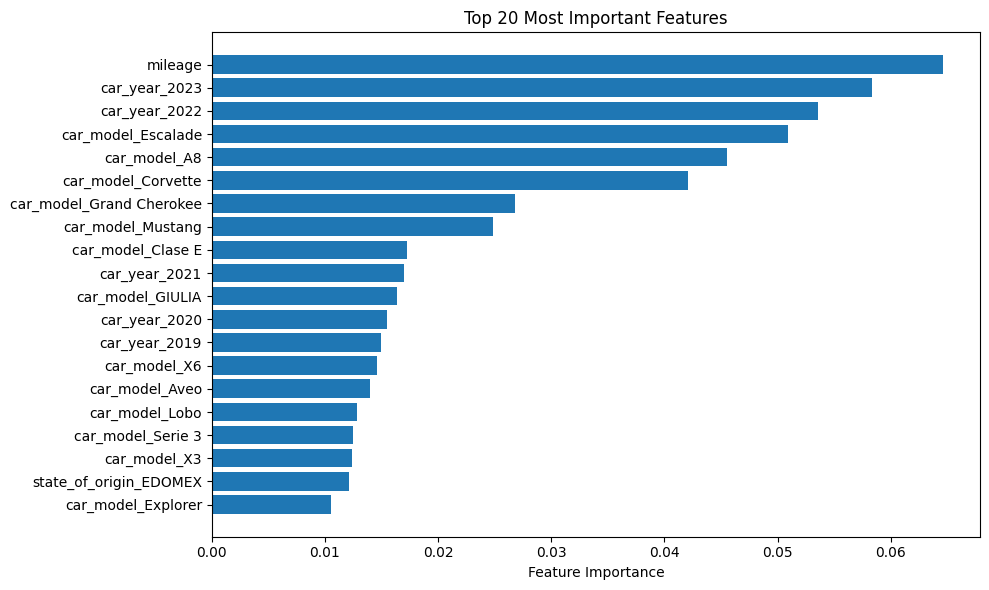

In [21]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X_encoded.columns[indices][:20]

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], importances[indices][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features")
plt.tight_layout()
plt.show()

In [22]:
importances = model.feature_importances_
features = X_encoded.columns

importances_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

important_features = importances_df[importances_df['importance'] > 0.005]
print(f"Using {len(important_features)} out of {len(features)} total features.")

Using 43 out of 476 total features.


In [23]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost MAE: {mae:.2f}")

XGBoost MAE: 27698.18


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=18,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"HyperTuned Random Forest MAE: {mae:.2f}")

HyperTuned Random Forest MAE: 36411.55


In [25]:
categorical_cols = X.select_dtypes(include='object').columns
for col in categorical_cols:
    unique_vals = X[col].nunique()
    if unique_vals > 30:
        print(f"{col}: {unique_vals} unique values")

car_brand: 33 unique values
car_model: 390 unique values
state_of_origin: 34 unique values


In [26]:
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Improved Random Forest MAE: {mae:.2f}")

Improved Random Forest MAE: 35275.29


In [27]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost MAE (with grouped categories): {mae:.2f}")

XGBoost MAE (with grouped categories): 25439.05


In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Tuned XGBoost MAE: {mae:.2f}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Tuned XGBoost MAE: 20081.66


In [29]:
X['car_year'] = pd.to_numeric(X['car_year'], errors='coerce')

X = X[X['car_year'].notna()]
y = y.loc[X.index]

X['car_year'] = X['car_year'].astype(int)

import datetime
current_year = datetime.datetime.now().year
X['car_age'] = current_year - X['car_year']
X = X.drop(columns=['car_year'])

In [30]:
import numpy as np
X['mileage_log'] = np.log1p(X['mileage'])
X = X.drop(columns=['mileage'])

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Improved RF with engineered features MAE: {mae:.2f}")

Improved RF with engineered features MAE: 27637.06


| Modelo                                   |     MAE |
|-------------------------------------------|--------:|
| Baseline                                  | 24484.23 |
| XGBoost                                   | 27940.94 |
| Improved RF with engineered features      | 28129.51 |
| Tuned XGBoost                             | 32438.89 |
| Improved Random Forest                    | 32646.83 |

In [32]:
def save_csv_to_path(df, file_path):
    df.to_csv(file_path, index=False)
    print(f"CSV saved to {file_path}")

save_csv_to_path(df_model, "../../data/silver/df_model.csv")

CSV saved to ../../data/silver/df_model.csv
